
https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists # Ссылка на задачу

#### Задание:

 Проиллюстрировать какие показатели влияют на решение кандидата на вакансию "Специалист Data Science" сменить работу (target = 1).




In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import copy
import phik
from phik.report import plot_correlation_matrix
from phik import report

# Устанавливаем библиотеки 

In [3]:
df = pd.read_csv("/Work/Job/hr_analytics/aug_train.csv")
df
# Открываем и смотрим данные

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [5]:
df.isnull().sum() # Кол-во пропусков

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [6]:
df.isna().mean() # % пропусков

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

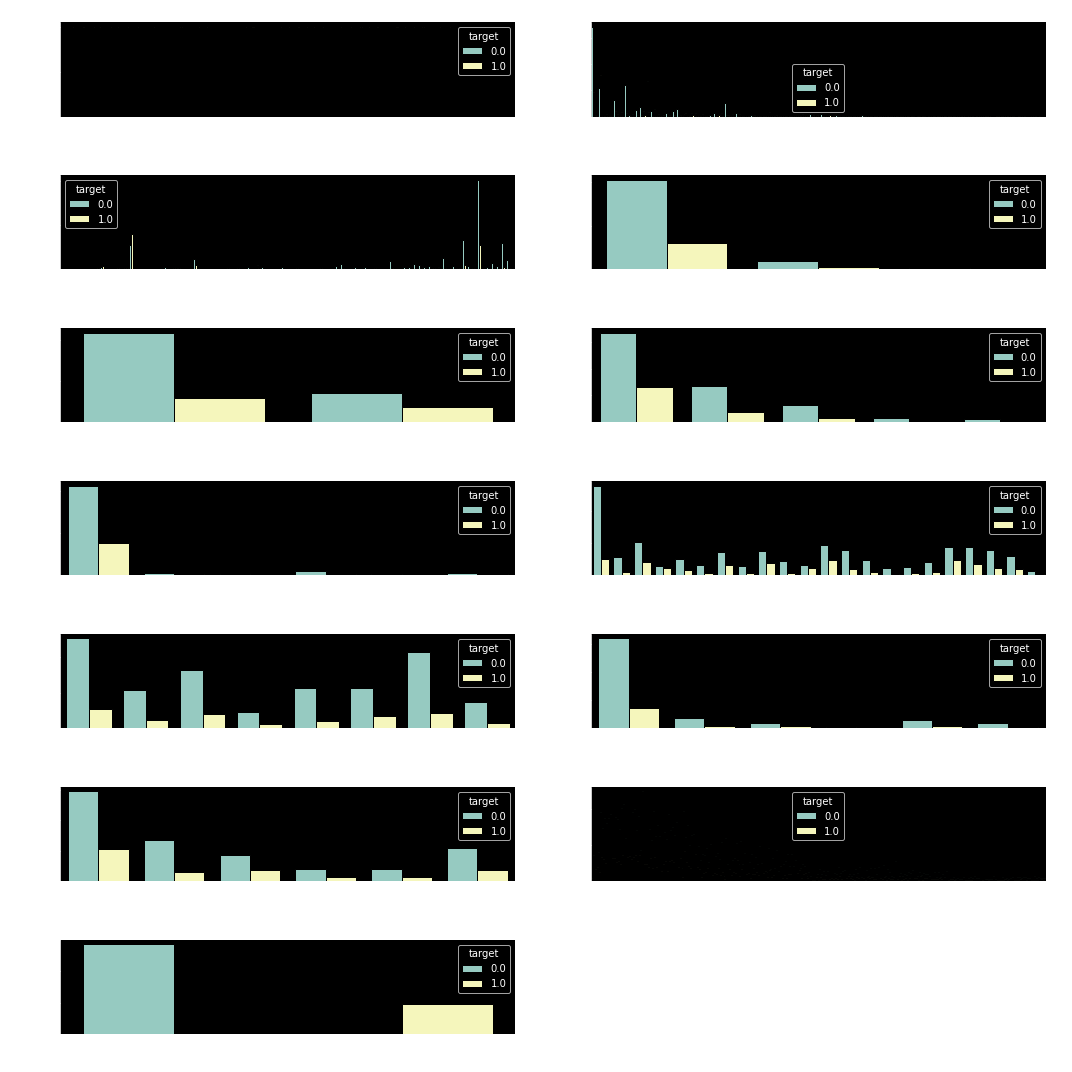

In [9]:

plt.figure(figsize=[15,15])
fft=["enrollee_id","city","city_development_index","gender","relevent_experience", "education_level","major_discipline", "experience","company_size","company_type","last_new_job","training_hours","target"]
n=1
for f in fft:
    plt.subplot(7,2,n)
    sns.countplot(x=f, hue='target', edgecolor="black", alpha=1, data=df)
    sns.despine()
    plt.title("Countplot of {}  by target".format(f))
    n=n+1
plt.tight_layout()
plt.show()
# Сраниваем все метрики с главной

### Первые выводы:
- [-] **enrollee_id**-------------id не несут информацию 
- [ ] **city** 
- [ ] **city_development_index** 
- [-] **gender**-----------------Соотношение по полу без явных различий
- [X] **relevent_experience**--У сотрудников без релевантного опыта больше желающих сменить работу, чем у сотрудников с релевантным опытом
- [-] **education_level**-------Различий не выявлено
- [-] **major_discipline**------Доля выпусников технических университетов самая большая среди аналитиков данных
- [X] **experience**------------Чем больше опыт работы, тем меньше желание сменить работу
- [-] **company_size**---------Соотношение по размеру компании без явных различий
- [-] **company_type**--------Большая часть аналитиков данных работает в обычных компаниях
- [-] **last_new_job**----------Соотношение по кол-ву работ без явных различий
- [ ] **training_hours** 
- [-] **target**-------------------Рассмотрим доли в %


### Начинаем разбирать оставшиеся метрики

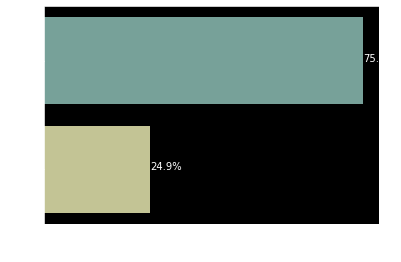

In [8]:
ax = sns.countplot(y="target", data=df, alpha=0.8)
total = df.shape[0]

for p in ax.patches:
    percent = '{:.1f}%'.format(100*(p.get_width()/total))
    x = p.get_x()+p.get_width()
    y = p.get_y()+(p.get_height())/2
    ax.annotate(percent,(x,y))


- [-] **target**---Всего 25 % от общей массы хотят сменить работу

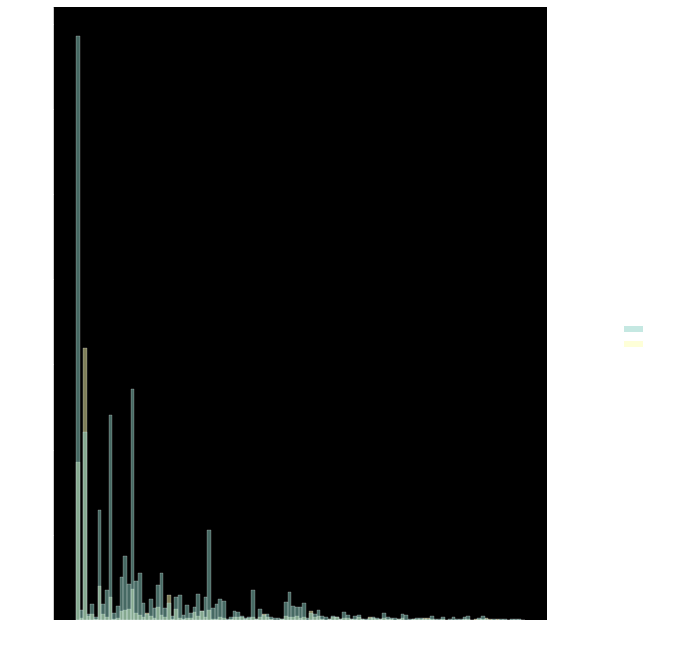

In [11]:
city_g = sns.displot(x='city',hue='target',data=df)
city_g.fig.set_size_inches(10,10) 

- [X] **city**---Видим аномалию по желающим сменить работу в одном из городов, где большое кол-во кандидатов

In [15]:
df.groupby('city')['target'].agg(['count','mean']).sort_values(['count','mean'], ascending=[False,False])
# Находим этот аномальный город, им является city_21

,count,mean
city,,
city_103,4355,0.213088
city_21,2702,0.591044
city_16,1533,0.116765
city_114,1336,0.099551
city_160,845,0.235503
...,...,...
city_121,3,0.333333
city_111,3,0.000000
city_129,3,0.000000


Рассмотрим city_21 по всем метрикам, возможно есть скрытый дисбаланс

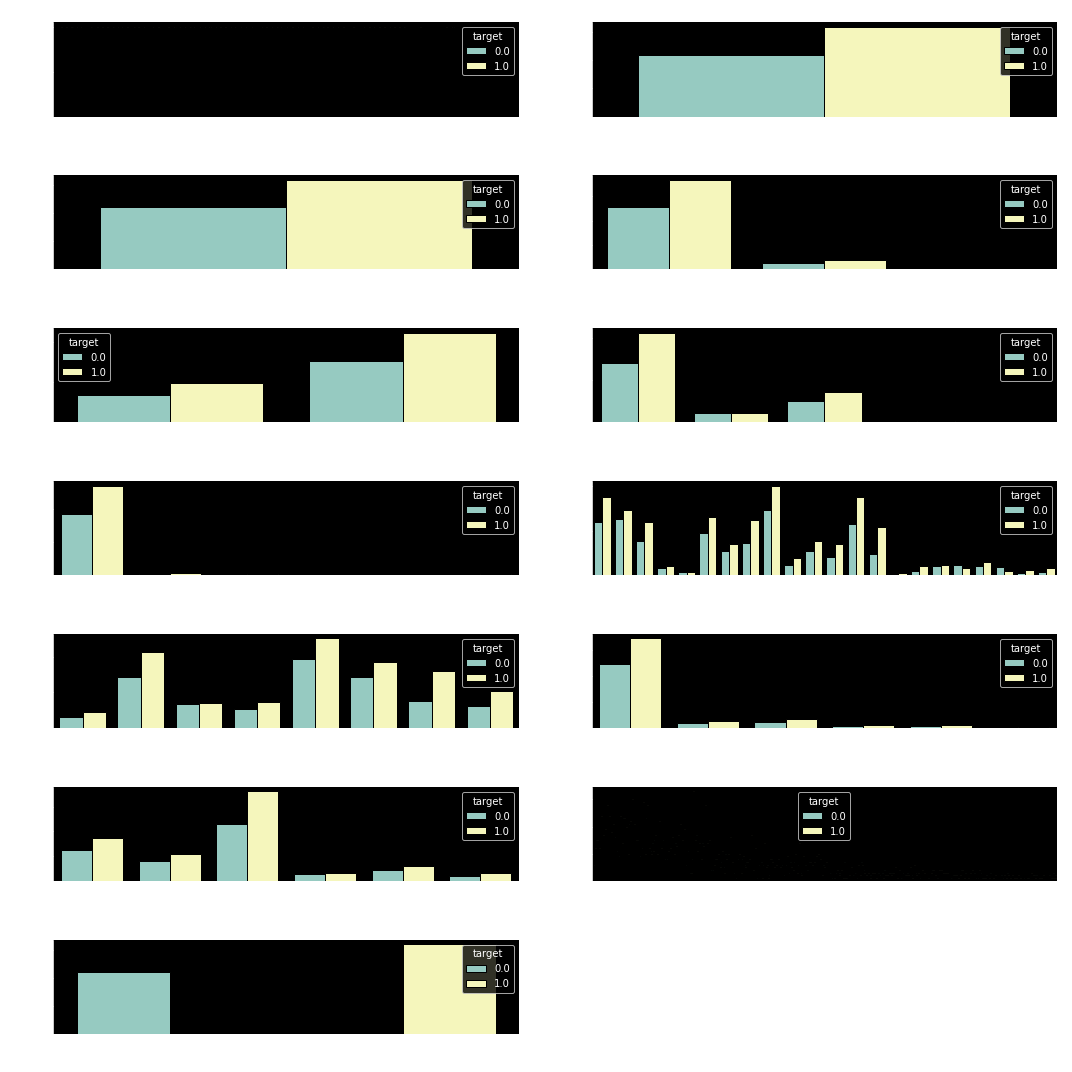

In [22]:
plt.figure(figsize=[15,15])
fft=["enrollee_id","city","city_development_index","gender","relevent_experience", "education_level","major_discipline", "experience","company_size","company_type","last_new_job","training_hours","target"]
n=1
for f in fft:
    plt.subplot(7,2,n)
    sns.countplot(x=f, hue='target', edgecolor="black", alpha=1, data=city_21)
    sns.despine()
    plt.title("Countplot of {}  by target".format(f))
    n=n+1
plt.tight_layout()
plt.show()

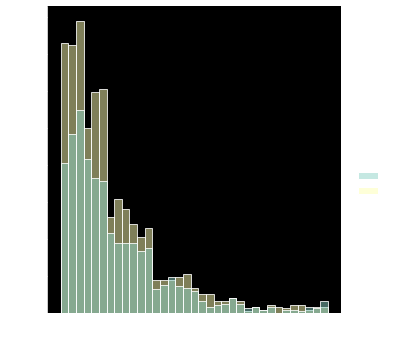

In [27]:
sns.displot(x ='training_hours',hue='target',data =city_21)

Приходим к выводу, что желание сменить работу в этом городе связано с чем-то, чего нет в наших данных

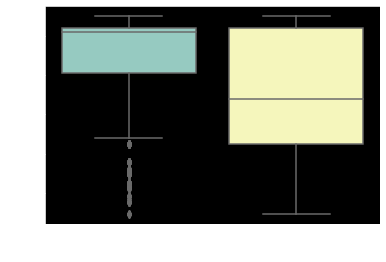

In [14]:
sns.boxplot(x='target',y='city_development_index',data=df)
xlabel='target'
ylabel = 'city_development_index'


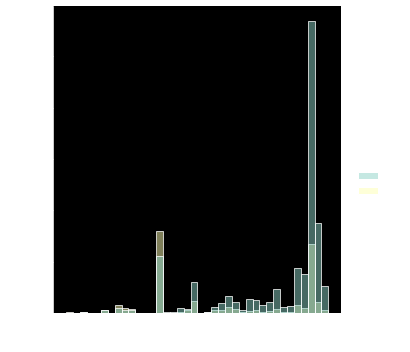

In [16]:
sns.displot(x ='city_development_index',hue='target',data =df)

- [X] **city_development_index**---Видим,что в городах с уровнем развития ниже 0.8 повальное желание сменить работу

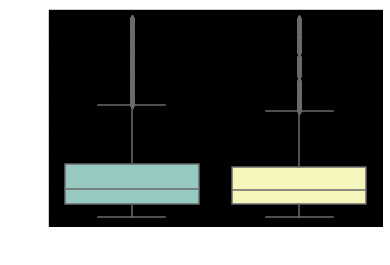

In [15]:
sns.boxplot(x='target',y='training_hours',data=df)
xlabel='target'
ylabel = 'training_hours'

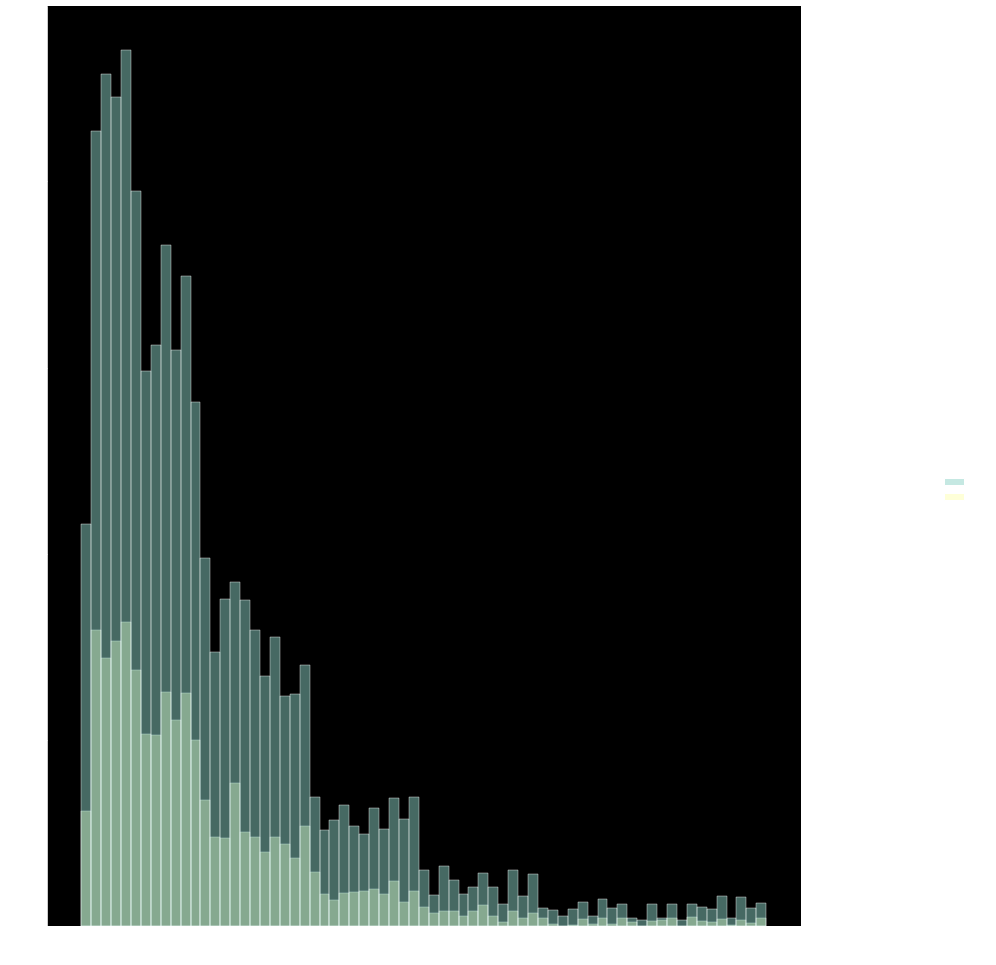

In [37]:

f = sns.displot(x='training_hours',hue= 'target',data = df)
f.fig.set_size_inches(15,15)

- [-] **training_hours** - расхождений по часам обучения не выявлено

Строим общую матрицу и делаем итоговые выводы

In [33]:
phik_overview=df.phik_matrix()

interval columns not set, guessing: ['enrollee_id', 'city_development_index', 'training_hours', 'target']


In [36]:
phik_overview['target'].sort_values(ascending=False)

target                    1.000000
city_development_index    0.482287
city                      0.477283
experience                0.238725
relevent_experience       0.199859
last_new_job              0.114708
enrolled_university       0.093803
education_level           0.075999
company_size              0.071953
enrollee_id               0.067472
company_type              0.066792
major_discipline          0.029200
training_hours            0.026849
gender                    0.013202
Name: target, dtype: float64

<AxesSubplot:>

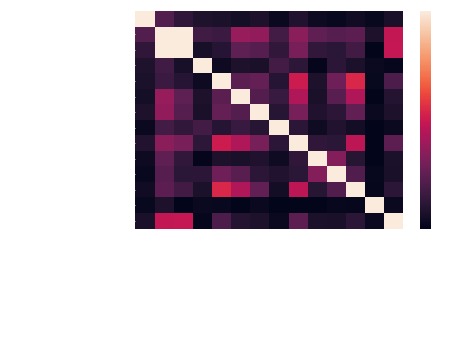

In [22]:
sns.heatmap(phik_overview)

### Итог:
Основные показатели(в %, по убыванию) которые влияют на решение о смене работы кандидатов на вакансию "Специалист Data Science":

- [0.48] **city_development_index**---Видим,что в городах с уровнем развития ниже 0.8 повальное желание сменить работу
- [0.48] **city**---------------------------Видим аномалию по желающим сменить работу в одном из городов, где большое кол-во кандидатов
- [0.23] **experience**------------------Чем больше опыт работы, тем меньше желание сменить работу
- [0.20] **relevent_experience**--------У сотрудников без релевантного опыта больше желающих сменить работу, чем у сотрудников с релевантным опытом

## Выводы:

### Основным фактором на смену работы у Дата Саентистов влияет уровень развития города. 

### Опыт в профессии тоже влияет на смену деятельности - чем меньше опыт, тем больше вероятность желания сменить работу.